In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import re
import os

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler

In [2]:
plt.style.use('ggplot')

SEED = 42
np.random.seed(SEED)

TARGET = "Survived"
TRAIN_SET = "train.csv"
TEST_SET = 'test.csv'

In [3]:
df_train = pd.read_csv(TRAIN_SET)
df_test = pd.read_csv(TEST_SET)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

## First Intuition

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
numerical_variables = [var for var in df_train.columns if df_train[var].dtypes != 'O']
numerical_variables.pop(numerical_variables.index(TARGET))
numerical_variables_num = len(numerical_variables)
print('Number of numerical variables: ', numerical_variables_num)
for var in numerical_variables:
    print(var, end=' - ')

Number of numerical variables:  6
PassengerId - Pclass - Age - SibSp - Parch - Fare - 

In [7]:
discrete_vars = [var for var in numerical_variables if len(df_train[var].unique()) < 100]
discrete_vars_num = len(discrete_vars)
print('Number of discrete variables: ', discrete_vars_num)
for var in discrete_vars:
    print(var, end=' - ')

Number of discrete variables:  4
Pclass - Age - SibSp - Parch - 

In [8]:
continuous_vars = [var for var in numerical_variables if var not in discrete_vars+['PassengerId']]
print('Number of continuous variables: ', len(continuous_vars))
for var in continuous_vars:
    print(var, end=' - ')

Number of continuous variables:  1
Fare - 

In [9]:
categorical_variables = [var for var in df_train.columns if df_train[var].dtypes == 'O']
categorical_variables_num = len(categorical_variables)
print('Number of categorical variables: ', categorical_variables_num)
for var in categorical_variables:
    print(var, end=' - ')

Number of categorical variables:  5
Name - Sex - Ticket - Cabin - Embarked - 

In [10]:
print("Number of complete duplicates: ", df_train.duplicated().sum())

Number of complete duplicates:  0


In [11]:
print(f"Number of nulls in features: {df_train.isnull().sum().sum()}")

Number of nulls in features: 866


In [12]:
null_variables_in_numerics = [var for var in numerical_variables if df_train[var].isnull().sum() > 0]
print(f"Number of null features: {len(null_variables_in_numerics)}")
print(f"Number of nulls in numerical features: {df_train[null_variables_in_numerics].isnull().sum().sum()}")
num_nulls = df_train[numerical_variables].isnull().sum().sort_values(ascending=False)
for row in num_nulls.iteritems():
    print(f"{row[0]}    \t{row[1] }nulls \t{row[1]/df_train.shape[0]:.3f}%")

Number of null features: 1
Number of nulls in numerical features: 177
Age    	177nulls 	0.199%
Fare    	0nulls 	0.000%
Parch    	0nulls 	0.000%
SibSp    	0nulls 	0.000%
Pclass    	0nulls 	0.000%
PassengerId    	0nulls 	0.000%


In [13]:
null_variables_in_categoric = [var for var in categorical_variables if df_train[var].isnull().sum() > 0]
print(f"Number of null features: {len(null_variables_in_categoric)}")
print(f"Number of nulls in categorical features: {df_train[null_variables_in_categoric].isnull().sum().sum()}")
num_nulls = df_train[categorical_variables].isnull().sum().sort_values(ascending=False)
for row in num_nulls.iteritems():
    print(f"{row[0]}   \t{row[1]} nulls \t{row[1]/df_train.shape[0]:.3f}%")

Number of null features: 2
Number of nulls in categorical features: 689
Cabin   	687 nulls 	0.771%
Embarked   	2 nulls 	0.002%
Ticket   	0 nulls 	0.000%
Sex   	0 nulls 	0.000%
Name   	0 nulls 	0.000%


### First Intuition Summary
* 891 records. 
* 12 feature + target.
* 7 numerical feature include (id + target).
* 5 categorical features.
* 0 complete duplicates.
* 866 null value in all features.
* 177 nulls in numerical features.
* 689 nulls in categorical features.

## Target vs All

First we extract the meaningfull information from the 'Name'.

In [14]:
def get_title_from_name(passenger_name):
    line = passenger_name
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
df_train['Title'] = df_train['Name'].apply(get_title_from_name)
df_test['Title'] = df_test['Name'].apply(get_title_from_name)

categorical_variables.pop(categorical_variables.index('Name'));
categorical_variables += ['Title']

In [15]:
df_train[TARGET].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

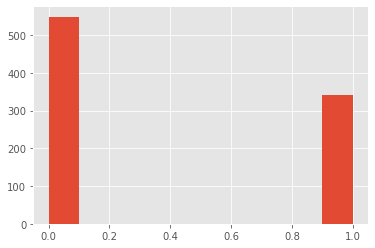

In [16]:
df_train[TARGET].hist();

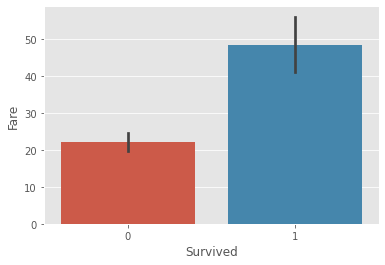

In [17]:
for var in continuous_vars:
    sns.barplot(data=df_train, y=var, x=TARGET)
    plt.show();

Who paid more has more chance to survive than he who doesn't. 

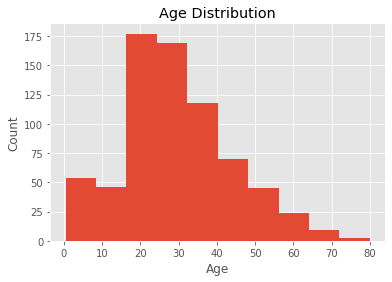

In [18]:
plt.hist(df_train['Age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution');

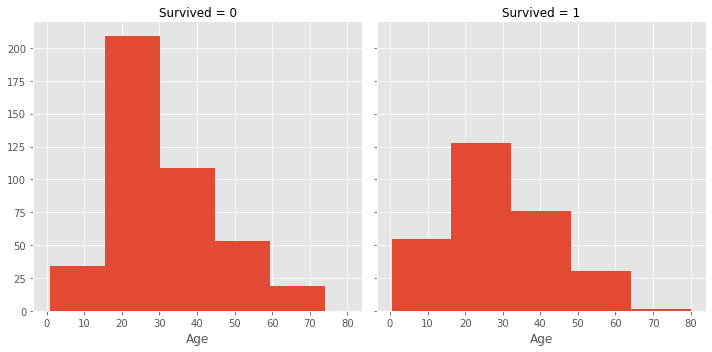

In [19]:
g = sns.FacetGrid(df_train, col=TARGET,height=5, aspect=1)
g.map(plt.hist, 'Age', bins=5);

In [20]:
df_train_copy = df_train.copy()
df_train_copy['AgeBand'] = pd.cut(df_train['Age'], 5)
tmp = df_train_copy.groupby('AgeBand')['AgeBand'].count().sort_values(ascending=False)
pd.DataFrame(columns=['Count'], data=tmp.values, index=tmp.keys())

,Count
AgeBand,
"(16.336, 32.252]",346
"(32.252, 48.168]",188
"(0.34, 16.336]",100
"(48.168, 64.084]",69
"(64.084, 80.0]",11


In [21]:
df_train_copy[['AgeBand', TARGET]].groupby('AgeBand').mean().sort_values(by=TARGET, ascending=False)

,Survived
AgeBand,
"(0.34, 16.336]",0.550000
"(48.168, 64.084]",0.434783
"(32.252, 48.168]",0.404255
"(16.336, 32.252]",0.369942
"(64.084, 80.0]",0.090909


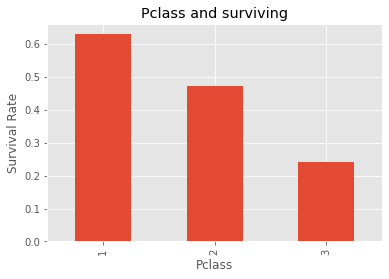

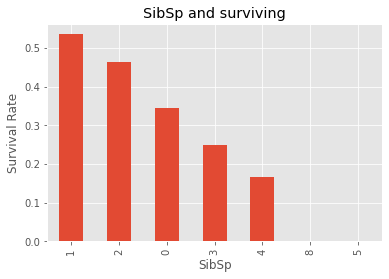

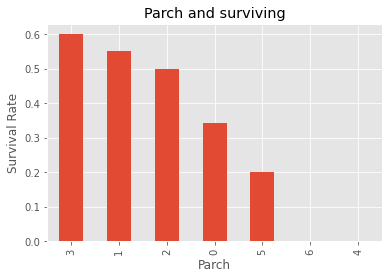

In [22]:
for i, var in enumerate(discrete_vars):
    if var == 'Age':
        continue
        
    df = df_train.groupby(var)[TARGET].mean().sort_values(ascending=False)
    df.plot.bar()
    plt.ylabel('Survival Rate')
    plt.title(f'{var} and surviving')
    plt.show();

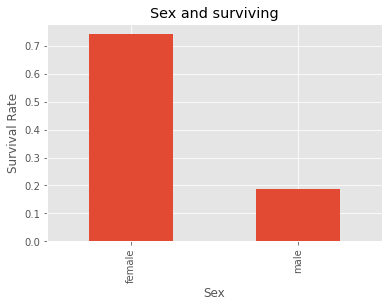

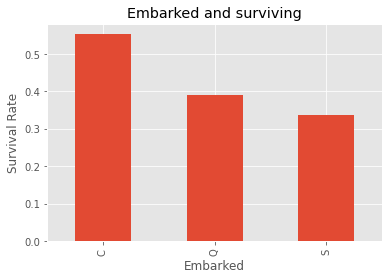

In [ ]:
for i, var in enumerate(categorical_variables):
    if var in ['Name', 'Ticket', 'Cabin']:
        continue
        
    df = df_train.groupby(var)[TARGET].mean().sort_values(ascending=False)
    df.plot.bar()
    plt.ylabel('Survival Rate')
    plt.title(f'{var} and surviving')
    plt.show();

In [ ]:
df_survived = df_train[df_train[TARGET] == 1]
df_survived.groupby('Sex')['Sex'].count().sort_values(ascending=False).plot.bar()
plt.ylabel('Count')
plt.title('Survived');

In [ ]:
df_unsurvived = df_train[df_train[TARGET] == 0]
df_unsurvived.groupby('Sex')['Sex'].count().plot.bar();
plt.ylabel('Count')
plt.title('unSurvived');

In [ ]:
g = sns.catplot(data=df_train, x="Pclass", y=TARGET, hue="Sex",
                   height=6, kind="bar", palette=['blue', 'red'])
g.despine(left=True)
g = g.set_ylabels("Survival Rate")

In [ ]:
def get_ticket_prefix(data):
    Ticket = []
    for i in list(data.Ticket):
        if not i.isdigit() :
            Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
        else:
            Ticket.append("X")
    return Ticket
        
df_train['Ticket'] = get_ticket_prefix(df_train)
df_test['Ticket'] = get_ticket_prefix(df_test)

In [ ]:
plt.figure(figsize=(15, 5))
df_train.groupby('Ticket')[TARGET].mean().sort_values(ascending=False).plot.bar()
plt.ylabel('Survival Rate')
plt.title('Ticket and Surviving');

## Summary

* Rich and upper class people survived more than medium or lower class people.
* Women survived more than men.
* Children and adult people survived more than the rest.

## Categoricals Association

In [ ]:
cols = categorical_variables + ['Pclass'] + [TARGET]
n = len(cols)

**chi square test**

In [ ]:
def get_chi_test(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix, correction=True)
    return chi2

In [ ]:
df_corr = pd.DataFrame(data=np.zeros(shape=(n, n)), columns=cols, index=cols)

p_value_index = 1

for row in cols:
    for col in cols:
        df_corr.loc[row, col] = get_chi_test(df_train[row], df_train[col])[p_value_index]

alpha = 0.05
cmap = sns.cm.rocket_r
sns.heatmap(df_corr, vmin=1, vmax=0, annot=True, fmt='.3f')
plt.title('p-value');

**Cramér\'s V**

In [ ]:
# Reference
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
df_corr = pd.DataFrame(data=np.zeros(shape=(n, n)), columns=cols, index=cols)

p_value_index = 1

for row in cols:
    for col in cols:
        df_corr.loc[row, col] = cramers_v(df_train[row], df_train[col])

alpha = 0.05
cmap = sns.cm.rocket_r
sns.heatmap(df_corr, vmin=0, vmax=1, annot=True, fmt='.3f')
plt.title('Cramér\'s V');

## Summary
* Not surprisingly ('Sex', 'Embarked', 'Title', 'Pclass') are correlated with the survival.
* **'Ticket'** is correlated with the survival but 'Cabin' (p-value was 0.184) not. Tickets with same prefixes may have a similar class and survival.

# Feature Engineering

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder

In [ ]:
df_train = df_train.drop(['Name', 'Cabin', 'PassengerId'], axis=1)

test_id = df_test['PassengerId']
df_test = df_test.drop(['Name', 'Cabin', 'PassengerId'], axis=1)

In [ ]:
df_train.isnull().sum()

In [ ]:
df_test.isnull().sum()

In [ ]:
def fill_with_mode(train, test, features):
    train = train.copy()
    test = test.copy()
    
    for feature in features:
        mode = train[feature].mode()[0]
        
        train[feature] = train[feature].fillna(mode)
        test[feature] = test[feature].fillna(mode)
        
    return train, test

features_to_fill_with_mode = ['Embarked']
df_train, df_test = fill_with_mode(df_train, df_test, features_to_fill_with_mode)

In [ ]:
def fill_with_median(train, test, features):
    train = train.copy()
    test = test.copy()
    
    for feature in features:
        median = train[feature].dropna().median()
        
        train[feature] = train[feature].fillna(median)
        test[feature] = test[feature].fillna(median)
        
    return train, test

features_to_fill_with_median = ['Age', 'Fare']
df_train, df_test = fill_with_median(df_train, df_test, features_to_fill_with_median)

### Adding Features

In [ ]:
data_combine = [df_train, df_test]
for dataset in data_combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']

    
df_train = df_train.drop(['Parch', 'SibSp'], axis=1)
df_test = df_test.drop(['Parch', 'SibSp'], axis=1)

In [ ]:
# df_train['Age'] = pd.qcut(df_train['Age'], 4)
# df_test['Age'] = pd.qcut(df_test['Age'], 4) 

# df_train['Fare'] = pd.qcut(df_train['Fare'], 5)
# df_test['Fare'] = pd.qcut(df_test['Fare'], 5) 

In [ ]:
def to_ordinal_encoding(train, test, var):
    train = train.copy()
    test = test.copy()

    orderd_labels = train.groupby(var)[TARGET].mean().sort_values().index.tolist()
    ordinal_encoder = OrdinalEncoder(categories=[orderd_labels], handle_unknown='ignore')
    
    train[var] = ordinal_encoder.fit_transform(train[var].values.reshape(-1, 1))
    test[var] = ordinal_encoder.transform(test[var].values.reshape(-1, 1))
    
    return train, test

df_train['Pclass'] = df_train['Pclass'].astype(str)
df_test['Pclass'] = df_test['Pclass'].astype(str)

categ_feats = [var for var in df_train.columns if df_train[var].dtypes == 'O' and var != TARGET]
for var in categ_feats:
    df_train, df_test = to_ordinal_encoding(df_train, df_test, var)

In [ ]:
# df_train.drop([ 'Ticket', 'Embarked', 'Sex', 'FamilySize'], axis=1, inplace=True)
# df_test.drop([ 'Ticket', 'Embarked', 'Sex', 'FamilySize'], axis=1, inplace=True)

# df_train.drop([ 'Embarked' ], axis=1, inplace=True)
# df_test.drop([ 'Embarked' ], axis=1, inplace=True)

In [ ]:
df_train

In [ ]:
def transform_with_MinMax(train, test, features):
    train = train.copy()
    test = test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(train[features])
    
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    
    return train, test

def transform_with_Standard(train, test, features):
    train = train.copy()
    test = test.copy()
    
    scaler = StandardScaler()
    scaler.fit(train[features])
    
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    
    return train, test

In [ ]:
features = [var for var in df_train.columns if var not in [TARGET]]
df_train, df_test = transform_with_Standard(df_train, df_test, features)
# df_train, df_test = transform_with_MinMax(df_train, df_test, features)

# Modeling

In [ ]:
from sklearn.model_selection import cross_validate, GridSearchCV


from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X_train = df_train.drop([TARGET], axis=1)
y_train = df_train[TARGET]

In [ ]:
#Validation function
n_folds =  12
# n_folds =  342


def cross_validation(model):
    results = cross_validate(model, X_train, y_train, scoring='accuracy', cv=n_folds, return_train_score=True, n_jobs=-1)
    return results

In [ ]:
if os.path.exists("model_scores.csv"):
    df_scores = pd.read_csv("model_scores.csv", index_col="Model")
else:
    MLA_columns = ['Parameters', 'Train Accuracy Mean', "Test Accuracy Mean", "Test Std", 'Time']
    df_scores = pd.DataFrame(columns = MLA_columns)
    df_scores.index.name = 'Model'

In [ ]:
model_version = "_V1"

In [ ]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(random_state=SEED),
    ensemble.BaggingClassifier(random_state=SEED),
    ensemble.ExtraTreesClassifier(random_state=SEED),
    ensemble.GradientBoostingClassifier(random_state=SEED),
    ensemble.RandomForestClassifier(random_state=SEED),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(random_state=SEED),
    
    #GLM
    linear_model.LogisticRegressionCV(random_state=SEED),
    linear_model.PassiveAggressiveClassifier(random_state=SEED),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(random_state=SEED),
    linear_model.Perceptron(random_state=SEED),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(random_state=SEED),
    tree.ExtraTreeClassifier(random_state=SEED),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    XGBClassifier(random_state=SEED)    
    ]

In [ ]:
# Reference
# https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook#Step-5:-Model-Data

#index through MLA and save performance to table
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__ + model_version
#     df_scores.loc[row_index, 'Model'] = MLA_name
    df_scores.loc[MLA_name, 'Parameters'] = str(alg.get_params())
    
    cv_results = cross_validation(alg)

    df_scores.loc[MLA_name, 'Time'] = cv_results['fit_time'].mean()
    df_scores.loc[MLA_name, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    df_scores.loc[MLA_name, 'Test Accuracy Mean'] = cv_results['test_score'].mean()
    df_scores.loc[MLA_name, 'Test Std'] = cv_results['test_score'].std()   

    
df_scores.sort_values(by = ['Test Accuracy Mean'], ascending=False, inplace=True)
df_scores

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Test Accuracy Mean', y=df_scores.index, data=df_scores, color='r')
plt.title('Machine Learning Algorithm Test Accuracy \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm');

Lets explore more KNN, RandomForest, GradientBoosting and XGboost classifiers for the better preformance.

In [ ]:
model_version = "_V2"

**K Nearest Neighbor**

In [ ]:
%%time

param_grid = {'n_neighbors': [5, 6,7,8,9, 11,12,14,16,18, 19, 20, 21],
             }
clf = KNeighborsClassifier()

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=n_folds, scoring="accuracy", return_train_score=True, n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(best_params) 


clf = KNeighborsClassifier(**best_params, n_jobs=-1)
model_name = clf.__class__.__name__ + model_version

cv_results = cross_validation(clf)


df_scores.loc[model_name, 'Parameters'] = str(clf.get_params())
df_scores.loc[model_name, 'Time'] = cv_results['fit_time'].mean()
df_scores.loc[model_name, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
df_scores.loc[model_name, 'Test Accuracy Mean'] = cv_results['test_score'].mean()
df_scores.loc[model_name, 'Test Std'] = cv_results['test_score'].std()
df_scores.loc[model_name].to_frame()

**Decision Tree Classifier**

In [ ]:
%%time

param_grid = {'max_depth': [4, 8, 16, 32]
             }

clf = DecisionTreeClassifier(random_state=SEED)

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=n_folds, scoring="accuracy", return_train_score=True, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(best_params) 

clf = DecisionTreeClassifier(**best_params, random_state=SEED)
model_name = clf.__class__.__name__ + model_version

cv_results = cross_validation(clf)


df_scores.loc[model_name, 'Parameters'] = str(clf.get_params())
df_scores.loc[model_name, 'Time'] = cv_results['fit_time'].mean()
df_scores.loc[model_name, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
df_scores.loc[model_name, 'Test Accuracy Mean'] = cv_results['test_score'].mean()
df_scores.loc[model_name, 'Test Std'] = cv_results['test_score'].std()
df_scores.loc[model_name].to_frame()

In [ ]:
clf.fit(X_train, y_train)
f = pd.DataFrame(columns=['Feature', 'Importance'])
f['Feature'] =  X_train.columns
f['Importance'] = clf.feature_importances_
f.sort_values('Importance', ascending=False)

**Random Forest Classifier**

In [ ]:
%%time

param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [4, 8, 16],
             }

clf = RandomForestClassifier(random_state=SEED, n_jobs=5)

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=n_folds, scoring="accuracy", return_train_score=True, n_jobs=5, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(best_params)

clf = RandomForestClassifier(**best_params, n_jobs=-1, random_state=SEED)
model_name = clf.__class__.__name__ + model_version

cv_results = cross_validation(clf)


df_scores.loc[model_name, 'Parameters'] = str(clf.get_params())
df_scores.loc[model_name, 'Time'] = cv_results['fit_time'].mean()
df_scores.loc[model_name, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
df_scores.loc[model_name, 'Test Accuracy Mean'] = cv_results['test_score'].mean()
df_scores.loc[model_name, 'Test Std'] = cv_results['test_score'].std()
df_scores.loc[model_name].to_frame()

In [ ]:
clf.fit(X_train, y_train)
f = pd.DataFrame(columns=['Feature', 'Importance'])
f['Feature'] =  X_train.columns
f['Importance'] = clf.feature_importances_
f.sort_values('Importance', ascending=False)

In [ ]:
df_scores.sort_values('Test Accuracy Mean', ascending=False, inplace=True)
df_scores.to_csv('model_scores.csv', index=True)
df_scores

# Submission

In [ ]:
clf = RandomForestClassifier(**{'max_depth': 8, 'n_estimators': 100}, random_state=SEED)
clf.fit(X_train, y_train)
preds = clf.predict(df_test)

In [ ]:
# clf = KNeighborsClassifier(**{'n_neighbors': 6})
# clf.fit(X_train, y_train)
# preds = clf.predict(df_test)

In [ ]:
sub = pd.DataFrame()
sub['PassengerId'] = test_id
sub[TARGET] = preds
sub.to_csv("submission.csv", index=False)